# Tutorial: Entendimiento de los datos RaSa

Continuando con el proyecto de consultoria de Wide World Importers, el primer paso para iniciar la comprensión de los datos es explorar y entender las fuentes de datos disponibles. Note que esto también nos ayuda a comprender mejor la organización.

## Configuración e importe de paquetes
Se utilizará el paquete de pandas profiling para apoyar el análisis estadístico, y se importan los paquetes de python
necesarios

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.types import StructType
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import FloatType, StringType, IntegerType, DateType
from pyspark.sql.functions import udf, col, length, isnan, when, count
import pyspark.sql.functions as f
import os 
from datetime import datetime
from pyspark.sql import types as t
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import numpy as np

C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Configuración del controlador e inicio de sesion Spark

In [2]:
path_jar_driver = 'C:\Program Files (x86)\MySQL\Connector J 8.0\mysql-connector-java-8.0.28.jar'

In [3]:
#Configuración de la sesión
conf=SparkConf() \
    .set('spark.driver.extraClassPath', path_jar_driver)

spark_context = SparkContext(conf=conf)
sql_context = SQLContext(spark_context)
spark = sql_context.sparkSession

C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\pyspark\sql\context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [4]:
# Si quiere practicar la conexion con el servidor de base de datos:
db_connection_string = 'jdbc:mysql://157.253.236.120:8080/RaSaTransaccional'
# El usuario es su estudiante _i asignado y su contraseña la encontrará en el archivo excel de Coursera 
db_user = 'Estudiante_22_202415'
db_psswd = 'Estudiante_201117125'

PATH='./'

## Perfilamiento de los datos
El perfilamiento se basa en varios aspectos: **entendimiento general** de los datos compartidos, validación de **reglas de negocio**, **análisis descriptivo** utilizando estadística descriptiva y diagramas para la visualización de los datos y **análisis de calidad**. El primero hace referencia a tener una comprensiòn global antes de entrar en los detalles, la segunda sobre las reglas, corresponden a especificaciones dadas por el negocio en relación con los datos, un ejemplo de regla de negocio dada es: "Todo producto de la canasta familiar debe tener un precio de IVA equivalente a 19%", dada esta regla de negocio, se debe revisar en los datos suministrados que no hayan valores de IVA menores a 19%. En el tercer aspecto, relacionado con el análisis descriptivo, se revisan estadísticas: mínimo, máximo, media, mediana, distribuciones de los datos, valores nulos, cardinalidad con el fin de comprender en mayor nivel de profundidad los datos compartidos.


### Información dada por la organización relacionada con los datos
RaSA de forma conjunta con un grupo de consultores de inteligencia de negocios, ha trabajado en una especificación de los primeros análisis que quiere que usted realice. En esta primera fase, a partir de estos análisis propuestos, la empresa le ha entregado una serie de fuentes de datos y requiere que usted realice los siguientes entregables relacionados con la etapa de entendimiento de datos:

Dichos datos pueden tener errores ya que no han sido utilizados previamente para ser analizados. La empresa nos da información adicional sobre los datos:

- Las áreas de servicios reportadas cubren todos los condados del país
- Los tipos de beneficios con límite cuantitativo deben tener una cantidad límite diferente de cero en los planes que los ofrecen.
- Las fuentes FuenteAreasDeServicio_Copia_E y FuenteTiposBeneficio_Copia_E comparten información de los años 2017 al 2019
- La empresa comparte 5409 áreas de servicios y 170 tipos de beneficios.
- El valor máximo Copago y Coseguro para el año 2018 es respectivamente 3300 y 100.
- Además, les comparte información de 301 planes para 2017 y de 422 para el año 2018.
- Existen 15 y 5 diferentes condiciones de copago y coseguro respectivamente.


### Conexión a fuente de datos y acceso a los datos

#### Conexión a fuente de datos
A continuación encuentra las funciones para conectarse a la fuente de datos (archivo csv o base de datos) y retornar un dataframe que es el que se utilizará posteriormente para manipular los datos.

In [5]:
def obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd):
    df_bd = spark.read.format('jdbc')\
        .option('url', db_connection_string) \
        .option('dbtable', sql) \
        .option('user', db_user) \
        .option('password', db_psswd) \
        .option('driver', 'com.mysql.cj.jdbc.Driver') \
        .load()
    return df_bd

#### Cargue de datos
Para consultar desde la base de datos se puede acceder directamente a la tabla dado su nombre o se puede especificar la sentencia SQL de un "SELECT" completo para traer la información total o parcial de la tabla que se requiere. A continuación un ejemplo de cada uno de estos usos. 
Acceso directo para el caso de órdenes y acceso con sentencia SQL para el caso de detallesOrdenes.

In [30]:
sql_fuentes = 'FuenteCondicionesDePago_Copia_E'

In [31]:
#Se cargan los dataframes desde la base de datos
fuentes = obtener_dataframe_de_bd(db_connection_string, sql_fuentes, db_user, db_psswd)

### Entendimiento general de datos "Fuente Condiciones de Pago"

Para ver una muestra de los datos, utilice el comando <i>show</i> ingresando el número de filas que quiere ver

In [32]:
fuentes.show(31)

+---------------------+--------------------+-------------+
|IdCondicionesDePago_T|         Descripcion|         Tipo|
+---------------------+--------------------+-------------+
|                  187|Copay with deduct...|       Copago|
|                  204|       Copay per Day|       Copago|
|                   45|         Coinsurance|     Coseguro|
|                   85|Copay per Day bef...|       Copago|
|                   18|No Charge after d...|     Coseguro|
|                  136|Copay per Stay wi...|       Copago|
|                   27|Coinsurance after...|     Coseguro|
|                  238|               Copay|       Copago|
|                  207|No Charge after d...|       Copago|
|                  153|Copay after deduc...|       Copago|
|                   36|      Not Applicable|     Coseguro|
|                   17|Copay per Day aft...|       Copago|
|                  119|Copay per Day wit...|       Copago|
|                  170|Copay before dedu...|       Copag

Como puede observar en la tabla de ordenes tenemos información **relacionada con el cliente, el empleado y con la órden**. La información del cliente es su identificador <i>ID_de_cliente</i>, el identificador de la persona que eligió la órden <i>eleccionado_por_ID_de_persona</i>, el identificador de la persona de contacto <i>ID_de_persona_de_contacto</i>, el <i>Número_de_pedido_de_compra_del_cliente</i>. La información del empleado es su identificador <i>ID_de_vendedor</i>. La información de la órden es: el identificador de la órden <i>ID_de_pedido</i>, el identificador que indica si es un pedido pendiente <i>ID_de_pedido_pendiente</i>, la fecha en la que se realizó el pedido <i>Fecha_de_pedido</i>, la fecha de entrega esperada del pedido <i>Fecha_de_entrega_esperada</i> y <i>Pedido_pendiente_de_suministro_insuficiente</i> que indica si es un pedido pendiente o no.
El esquema de un DataFrame incluye los nombres de las columnas asi como el tipo de dato. Recuerde que tipo de dato (e.g., booleano, caracteres, enteros, flotantes, colecciones) es diferente a tipo de variable (numérica y categórica).

In [33]:
fuentes.schema

StructType(List(StructField(IdCondicionesDePago_T,IntegerType,true),StructField(Descripcion,StringType,true),StructField(Tipo,StringType,true)))

Por otra parte, en los detalles de ordenes se tiene **información del pedido y del producto**. Del pedido se tiene el identificador del detalle <i>Detalle_orden_ID</i>, el identificador de la orden a la que está relacionado cada detalle <i>ID_de_pedido</i>, la <i>Cantidad_seleccionada</i> del producto para la orden, la fecha de selección <i>Seleccion_completada_cuando</i>. Del producto tenemos el <i>ID_Producto</i>, su <i>Descripcion</i>, el tipo de paquete <i>ID_Tipo_Paquete</i> (Ej. 1.Bolsa, 4. Caja), la <i>Cantidad</i>, el <i>Precio_unitario</i>, y la <i>Tasa_impuesto</i> asociada a ese producto. Una primera aclaración a solicitar por parte del negocio es cuál es la diferencia entre cantidad y cantidad seleccionada

**¿Qué es una fila de cada fuente compartida?**
Con estos análisis podemos concluir que una fila de órdenes representa la órden realizada por un cliente y atendida por un empleado. Mientras que el detalle de órden coincide con su nombre y contiene el detalle de cada producto solicitado en una órden.

Una vez entendida en términos generales la estructura de los datos, es necesario conocer la cantidad de datos disponibles, esto se hace con count() y con columns, que retornan el número de filas y número de columnas respectivamente.

In [34]:
print((fuentes.count(), len(fuentes.columns)))

(31, 3)


**¿Cuantos datos nos compartieron para el proyecto?**
En total tenemos 31 tipos de Fuentes de Condiciones de Pago en un total de 3 variables a revisar de las cuales 1 es un ID que identifica el tipo de condición de pago y 2 variables string que relacionan los tipos de pago (copagos y coseguros).

### Revisión de reglas de negocio 

Primero se confirman las reglas proporcionadas por el negocio, la primera que asegura que existen 15 tipos de copago y 5 de coseguro

In [35]:
descripcion = fuentes.select("Tipo", "Descripcion").groupBy("Tipo").count()
descripcion.show()

+-------------+-----+
|         Tipo|count|
+-------------+-----+
|     Copagado|    1|
|  Coseguridad|    1|
|       Copago|   19|
|SinTipoCopago|    1|
|          NaN|    2|
|     Coseguro|    7|
+-------------+-----+



Revisamos las categorias de Descripción cuando nos enfocamos en el ***"Tipo" == "Copago"***. Encontramos 14 diferentes categorias, pero en la tabla general encontramos el tipo Copagado podría considerarse dentro de "Copago". Haciendo este ajuste en el select encontramos que solo existen 14 descripciones de este tipo. Existen dos descripciones ***No Charge after d*** y ***No Charge*** que pueden referirse al tipo Coseguro y que están incorrectamente asignadas

In [38]:
fuentes.select("Descripcion").where(fuentes["Tipo"].isin("Copago", "pago")).distinct().show()

+--------------------+
|         Descripcion|
+--------------------+
|      Copay per Stay|
|No Charge after d...|
|           No Charge|
|Copay before dedu...|
|Copay per Stay wi...|
|Copay per Stay af...|
|Copay per Day aft...|
|Copay with deduct...|
|Copay after deduc...|
|Copay per Day bef...|
|Copay per Stay be...|
|Copay per Day wit...|
|               Copay|
|       Copay per Day|
+--------------------+



Revisamos las categorias de Descripción cuando nos enfocamos en el ***"Tipo" == "Coseguro"***. Encontramos 4 diferentes categorias. Exite una categoria en el tipo Copago llamada ***No Charge*** que puede referirse al 5 grupo de copago

In [39]:
fuentes.select("Descripcion").where(fuentes["Tipo"]=="Coseguro").distinct().show()

+--------------------+
|         Descripcion|
+--------------------+
|No Charge after d...|
|Coinsurance after...|
|         Coinsurance|
|      Not Applicable|
+--------------------+



In [43]:
fuentes.select("Descripcion").where(fuentes["Tipo"]=="NaN").distinct().show()
fuentes.select("IdCondicionesDePago_T").where(fuentes["Tipo"]=="NaN").distinct().show()

+--------------+
|   Descripcion|
+--------------+
|Copay per Stay|
+--------------+

+---------------------+
|IdCondicionesDePago_T|
+---------------------+
|                  221|
+---------------------+



Existe un caso de tipo Nan que corresponde a la descripción ***Copay per Stay*** con ID de condiciones ***221***. Este caso puede ser planteado al cliente para indagar si se trata de un error y corresponde a la categoria Copago - lo que podrian completar las 15 condiciones expuestas por el cliente

Como resultado de la comprobación de la regla de negocio: ***Existen 15 y 5 diferentes condiciones de copago y coseguro respectivamente*** se encuentra que existen diferencias entre lo reportado por el negocio y lo entregado en la tabla. En Copagos se podrían considerar 14 tipos y en Coseguros se encuentran 4 tipos, aunque puede tratarse de un error de asignación de categorias y no de faltantes en la base de datos

### Análisis descriptivo
Una vez cubierto lo básico de reglas de negocio, pasamos a perfilamiento estadístico. Para ver estadisticos generales como conteo, mínimo, máximo, desviación estandar y percentiles utilice summary()

In [44]:
fuentes.summary().show()

+-------+---------------------+--------------+-------------+
|summary|IdCondicionesDePago_T|   Descripcion|         Tipo|
+-------+---------------------+--------------+-------------+
|  count|                   31|            31|           31|
|   mean|   152.16129032258064|          null|          NaN|
| stddev|   161.75312398306122|          null|          NaN|
|    min|                    9|   Coinsurance|     Copagado|
|    25%|                   45|          null|          NaN|
|    50%|                  119|          null|          NaN|
|    75%|                  204|          null|          NaN|
|    max|                  714|Not Applicable|SinTipoCopago|
+-------+---------------------+--------------+-------------+



In [54]:
fuentes.groupBy('Descripcion').pivot('Tipo').count().show()

+--------------------+--------+------+-----------+--------+----+-------------+
|         Descripcion|Copagado|Copago|Coseguridad|Coseguro| NaN|SinTipoCopago|
+--------------------+--------+------+-----------+--------+----+-------------+
|      Copay per Stay|    null|     1|       null|    null|   2|         null|
|No Charge after d...|    null|     2|       null|       1|null|         null|
|Coinsurance after...|    null|  null|       null|       2|null|         null|
|           No Charge|    null|     2|          1|    null|null|         null|
|Copay before dedu...|    null|     1|       null|    null|null|         null|
|Copay per Stay wi...|    null|     1|       null|    null|null|         null|
|Copay per Stay af...|    null|     2|       null|    null|null|            1|
|Copay per Day aft...|    null|     1|       null|    null|null|         null|
|Copay with deduct...|    null|     1|       null|    null|null|         null|
|         Coinsurance|    null|  null|       null|  

En las estadísticas anteriores ve

En las estadíticas de orden podemos observar que el valor promedio de precio unitario es 44.54, la cantidad promedio es 213 unidades y el promedio de cantidad seleccionada es 39.74


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

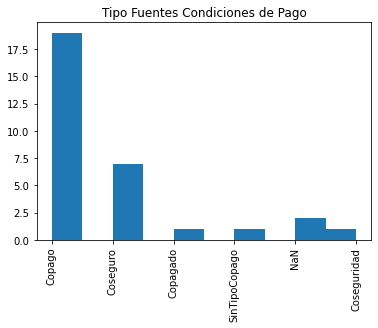

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.set_title('Tipo Fuentes Condiciones de Pago')
ax1.hist(np.array(fuentes.select('Tipo').collect()))
plt.xticks(rotation=90)

El análisis anterior es muy útil para variables de tipo numérico, sin embargo es incompleto para las variables de tipo caracter o las variables categoricas, por ende es necesario implementar nuestro propio código par obtener estadisticos como la moda y la mediana. A continuación obtenemos la moda para la variable Descripcion:

## Análisis de calidad de datos
La calidad de los datos consiste en validar la idoneidad de los datos analizando varias dimensiones, entre las cuales resaltamos:
- Completitud: Datos que no existen o no se conocen
- Unicidad (Duplicidad): Datos que son idénticos en diferentes registros o registros con valores idénticos en atributos en los que no debería ocurrir
- Consistencia: Esta medida se define por la validez o integridad del dato, en la definición de su estructura, al interior de una fila o entre diferentes filas de la misma fuente o de diferentes fuentes. El manejo de unidades en los datos y el significado del dato son generadores de inconsistencias.
- Validez: a nivel de formato y de sentido de los datos más alla de sus valores

Para asegurar una calidad mínima de los datos en estas dimensiones hay que entender su origen y posteriormente realizar un proceso de validación de cada una de las dimensiones de perfilamiento que llevará a un entendimiento de los datos disponibles.


A continuación se definen dos funciones, la primera cuenta los valores vacios por columna de dataframe, la segunda retorna un diccionario de columnas con cardinalidad superior al 50%

Te invito a revisar los recursos de calidad de datos que hemos visto en el curso, a continuacion ejemplos daremos algunos ejemplos por cada dimensión para el caso del tutorial

### Unicidad y validez

La unicidad se revisó en la segunda regla de negocio y la validez se reviso en el perfilamiento general, en la regla de negocio 3 y en el análisis de la descripción al final de la sección de revisión de reglas de negocio

### Completitud y validez

In [50]:
def contar_vacios(df):
    resultados = []
    for c in df.columns:
        vacios_1 = df.filter(df[c].isNull()).count()
        vacios_2 = df.filter(df[c] == "NaN").count()
        vacios = vacios_1 + vacios_2
        if vacios!=0:
            print('número de vacíos para columna '+c+': '+str( vacios ))
            resultados.append(vacios)
    return resultados

def cardinalidad(df):
    resultado = {}
    for c in df.columns:
        cardinalidad = df.select(col(c)).distinct().count()
        if cardinalidad>=df.count()*0.5:
            resultado[c] = cardinalidad
    return resultado

In [52]:
columnas_vacias_ordenes = contar_vacios(fuentes)

número de vacíos para columna Tipo: 2


In [53]:
columnas_alta_cardinalidad = cardinalidad(fuentes)

Como podemos observar para las ordenes las columnas Tipo tiene 2 vacios, definidos como NaN 
Respecto a cardinalidad, Ninguna columna tiene una cardinalidad superior al 50%.

### Consistencia
A nivel de consistencia algunos ejemplos de revisión son precios negativos, productos que aparecen en las ordenes pero que no esten registrados en la tabla de produtos. En nuestro caso vamos a verificar que todas las ordenes tengan detalle de orden y viceversa

In [34]:
#consistencia: revisar genially: definicion de consistencia
ids_ordenes = set([x.ID_de_pedido for x in ordenes.select('ID_de_pedido').collect()])
ids_detalles = set([x.ID_de_pedido for x in detallesOrdenes.select('ID_de_pedido').collect()])

len(ids_ordenes-ids_detalles), len(ids_detalles-ids_ordenes)

(44359, 28956)

Como se puede observar hay una diferencia de 44.359 ordenes que no tienen detalles y hay 28.956 detalles que no tienen orden. Ninguno de los casos tiene sentido en el contexto de WideWorldImporters. Esta inconsistencia se notifica al negocio dado que no hay forma de conocer cuáles son los registros que pueden tener ids que no existen

### Otras opciones de exploración
PySpark también da la opción de crear tablas de pivotes. En el siguiente ejemplo, se muestra cómo hacer una tabla que permite ver cuántas ordenes hay por cada <i>Fecha_de_pedido</i> y por cada <i>ID_de_vendedor</i>, es decir por fecha y por empleado cuantas ordenes existen:

Otro análisis muy útil es el de la correlación lineal entre dos variables, para ver la matriz de correlacion que mide esta dependencia o la fuerza de la relación lineal entre dos variables vamos a usar pandas, la interpretación es que si entre dos variables A y B  el valor obtenido es cercano a -1 o a 1, se interpreta como que A y B contienen la misma información y por ende no es necesario mantener ambas columnas

## Conclusiones/resultados


**Conclusiones generales:**

1. En la tabla de ordenes tenemos información **relacionada con el cliente, el empleado y con la órden**. Por otra parte, en los detalles de ordenes se tiene **información del pedido y del producto**
2. Una fila de órdenes representa la órden realizada por un cliente y atendida por un empleado. Mientras que el detalle de órden coincide con su nombre y contiene el detalle de cada producto solicitado en una órden.
3. ¿cuál es la diferencia entre cantidad y cantidad seleccionada?

**Conclusiones de reglas de negocio:**

1. La regla 1 no es completamente cierta, pues en los datos no hay ningun registro con tasa_de_impuesto de 10%, es necesario pedir aclaraciones al negocio en relación a este descubrimiento
2. La regla 2 no es cierta dado que el número de registros no parece coincidir con el número dado por el negocio, Hay 14.079 ordenes completamente repetidas y 258 registros que representan el mismo detalle de orden pero con valores distintos, los primeros se pueden eliminar, pero ¿qué deberíamos hacer con los segundos?
3. Los datos comienzan en enero 1 de 2014, sin embargo la regla 2 nos dice que debería ser desde 2013, ¿es un error o faltan datos?
4. Algunos formatos de fecha no coinciden con el dado en la regla 3, por ejemplo del atributo Fecha_de_pedido hay 20 mil registros que no tienen ese formato. En este caso el cambio de formato se puede implementar, ¿estan de acuerdo?
5. La descripcion de algunos productos es "a", ¿esto es correcto?

**Conclusiones de calidad:**

1. Las columnas Comentarios, Instrucciones_de_entrega y Comentarios_internos tienen un conteo igual a 0, es decir son columnas vacías por lo que se pueden eliminar
2. Vemos por ejemplo que el valor máximo de Cantidad indica valores anómalos o extremos, pues en su percentil 75% el valor máximo era 60, es decir, para el 75% de los datos, el valor de Cantidad no superaba el 70, pero el valor máximo es de 10 millones
3. Observamos que la columna ID_Tipo_Paquete solo toma el valor 7, que podría ser o no un error, se notifica al negocio.
4. Para las ordenes las columnas Seleccionado_por_ID_de_persona tiene 16662 vacios, ID_de_pedido_pendiente: 96905, Comentarios: 108291, Instrucciones_de_entrega: 108291, Comentarios_internos: 108291, Seleccion_completada_cuando: 5276, mientras que para los detalles de ordenes tenemos que las columnas con vacios son Precio_unitario: 7038 y Seleccion_completada_cuando: 3186.
5. Respecto a cardinalidad, solo la columna Detalle_orden_ID tiene una cardinalidad superior al 50%.
6. Como se puede observar hay una diferencia de 44.359 ordenes que no tienen detalles y hay 28.956 detalles que no tienen orden. Ninguno de los casos tiene sentido en el contexto de WideWorldImporters. ¿Tienen alguna forma de identificar cual detalle corresponde a cual orden?

**Usando herramientas:**

Seccion general del reporte:
1. Tenemos 14 variables y 88.258 registros (es decir, ordenes), de las cuales 7 son numericas, 2 categoricas, 1 booleana, 1 datetime y 3 no soportadas (la herramienta entiende tipo de variable como tipo de dato, asi que la información que nos da no es necesariamente correcta en este aspecto).

2. En los datos hay 29.3% de datos vacíos, (conclusión)

3. El archivo ocupa en memoria 7.5 MB

4. No hay registros duplicados

Sección de variables del reporte:

5. Note que para cada variable nos dan estadisticos como la media, mínimo y máximo asi como un histograma de distribución de la variable, para nuestros datos no observamos nada por fuera de lo comun. (Como valores extremos)

6. La variable ID_de_pedido tiene 61.3% de valores distintos, es decir, es una variable con alta cardinalidad. Este tipo de variables no aportan a las relaciones entre filas o columnas, por lo que suelen no ser útiles a la hora de hacer análitica.

7. La variable ID_cliente tiene solo el 0,8% de valores distintos, es decir que las ordenes que tenemos parecen ser de pocos clientes, pero que podrían ser recurrentes o fieles

8. Hay 10 empleados en los datos de ordenes

9. Seleccionado_por_ID_persona tiene 15,4% de datos vacíos, no es muy alto pero podríamos eliminarla si no es importante. Preguntar al negocio

10. ID_de_pedido_pendiente tiene un porcentaje de 89,5% de valores vacíos, es casi constante y las columnas constantes no aportan a los análisis, preguntar al negocio si hay algún inconveniente en borrar esta columna

11. Hay 1512 Fecha_de_pedido distintos, siendo el 3 de febrero del 2015 una de las fechas con más número de ordenes

12. Fecha_de_entrega_esperada y Seleccion_completada_cuando tienen alta cardinalidad

Sección de correlación:

13. Parecen haber columnas con correlaciones(Spearman) iguales a 1, esto significa que ambas columnas representan la misma información, idealmente no queremos columnas "repetidas", un ejemplo es ID_cliente y ID_de_persona_de_contacto, decidimos preguntarle al negocio si es necesario mantener ambas columnas

**Conclusiones de consultoria**

![Requerimiento](./Requerimiento.png)

Teniendo en cuenta el requerimiento de WWI, consideramos que es posible llevar a cabo una solucióon pues contamos con la información necesaria especificada en el análisis requerido, sin embargo es necesario realizar correcciones a los datos y obtener aclaraciones de parte del negocio para entender completamente la necesidad de negocio

Para comprobar su comprensión de esta sección, lo invitamos a responder la pregunta:

    ¿Qué funcionalidades de PySpark puedo utilizar para realizar el entendimiento de datos y cómo las puedo utilizar?
    
Como parte de nuestro trabajo es preveer posibles soluciones a las conclusiones de perfilamiento, por ende lo invitamos a responder:

    ¿Qué métodos podría utilizar para reemplazar los valores nulos de una columna por el promedio de la misma?

### Entendimiento general de datos "Fuente Condiciones de Pago"

#### Cargue de datos
Para consultar desde la base de datos se puede acceder directamente a la tabla dado su nombre o se puede especificar la sentencia SQL de un "SELECT" completo para traer la información total o parcial de la tabla que se requiere. A continuación un ejemplo de cada uno de estos usos. 
Acceso directo para el caso de órdenes y acceso con sentencia SQL para el caso de detallesOrdenes.

In [59]:
sql_areas = 'FuenteAreasDeServicio_Copia_E'

In [61]:
#Se cargan los dataframes desde la base de datos
areas = obtener_dataframe_de_bd(db_connection_string, sql_areas, db_user, db_psswd)

### Entendimiento general de datos "Fuente Condiciones de Pago"

Para ver una muestra de los datos, utilice el comando <i>show</i> ingresando el número de filas que quiere ver

In [62]:
areas.show(5)

+------------------+--------------------+-------------+-----------------+----------+------------+-----+--------+-----+
|IdAreaDeServicio_T|NombreAreaDeServicio|IdGeografia_T|          Condado|    Estado|PoblacionAct| Area|Densidad|Fecha|
+------------------+--------------------+-------------+-----------------+----------+------------+-----+--------+-----+
|         100622017|New Jersey - Medi...|        34005|Burlington County|New Jersey|    464269.0|805.0|   577.0| 2017|
|         101012018|New Jersey - Medi...|        34031|   Passaic County|New Jersey|    518117.0|185.0|  2801.0| 2018|
|          10132017|BlueOptions16842F...|        12031|     Duval County|   Florida|    999935.0|774.0|  1292.0| 2017|
|         101982018|New Jersey - Medi...|        34003|    Bergen County|New Jersey|    953819.0|234.0|  4076.0| 2018|
|         102012017|New Jersey - Medi...|        34021|    Mercer County|New Jersey|    385898.0|226.0|  1708.0| 2017|
+------------------+--------------------+-------

Como puede observar 

In [63]:
areas.schema

StructType(List(StructField(IdAreaDeServicio_T,IntegerType,true),StructField(NombreAreaDeServicio,StringType,true),StructField(IdGeografia_T,IntegerType,true),StructField(Condado,StringType,true),StructField(Estado,StringType,true),StructField(PoblacionAct,DoubleType,true),StructField(Area,DoubleType,true),StructField(Densidad,DoubleType,true),StructField(Fecha,IntegerType,true)))

Por otra parte, en lo

Una vez entendida en términos generales la estructura de los datos, es necesario conocer la cantidad de datos disponibles, esto se hace con count() y con columns, que retornan el número de filas y número de columnas respectivamente.

In [64]:
print((areas.count(), len(areas.columns)))

(188815, 9)


**¿Cuantos datos nos compartieron para el proyecto?**
En total tenemos 188815 instancias de Fuentes de areas de servicio en un total de 9 variables a revisar de las cuales 1 es un ID que identifica el tipo de servicio y 8 variables que muestran información sobre la ubicación de las áreas y fechas.

### Revisión de reglas de negocio 

Primero se confirman las reglas proporcionadas por el negocio, la primera que asegura que existen información desde 2017 al 2019

In [71]:
areas.agg({"Fecha": "max"}).show()
areas.agg({"Fecha": "min"}).show()

+----------+
|max(Fecha)|
+----------+
|      2018|
+----------+

+----------+
|min(Fecha)|
+----------+
|      1800|
+----------+



Se observa que el periodo de años de la tabla de Areas de Servicio está entre 1800 y 2018 - No corresponde a lo definido por el cliente

La siguiente regla asegura que las ***areas de servicio se distribuyen por todo el país***. Para este caso:

In [78]:
estados = areas.select("Estado").distinct()
num_estados = estados.count()
print(f"El número de estados donde se encuentran las áreas de servicio son: {num_estados}")
estados.show(35)

El número de estados donde se encuentran las áreas de servicio son: 35
+--------------+
|        Estado|
+--------------+
|        Hawaii|
|          Ohio|
|        Oregon|
|      Arkansas|
|         Texas|
|  North Dakota|
|  Pennsylvania|
|      Illinois|
|      Oklahoma|
|      Delaware|
|        Alaska|
|    New Mexico|
| West Virginia|
|      Missouri|
|       Georgia|
|       Montana|
|      Virginia|
|      Michigan|
|North Carolina|
|       Wyoming|
|        Kansas|
|    New Jersey|
|       Alabama|
|       Arizona|
|      Kentucky|
|     Louisiana|
|   Mississippi|
| New Hampshire|
|     Tennessee|
|       Florida|
|       Indiana|
|South Carolina|
|  South Dakota|
|     Wisconsin|
|         Maine|
+--------------+



In [79]:
condados = areas.select("Condado").distinct()
num_condados = condados.count()
print(f"El número de condados donde se encuentran las áreas de servicio son: {num_condados}")
estados.show(10)

El número de condados donde se encuentran las áreas de servicio son: 1398
+------------+
|      Estado|
+------------+
|      Hawaii|
|        Ohio|
|      Oregon|
|    Arkansas|
|       Texas|
|North Dakota|
|Pennsylvania|
|    Illinois|
|    Oklahoma|
|    Delaware|
+------------+
only showing top 10 rows



Como resultado se observa que se definen áreas de servicio solo para ***35 estados*** y ***1398*** condados

In [81]:
descripcion = areas.select("Condado", "IdGeografia_T").groupBy("Condado").count()
descripcion.show()

+--------------------+-----+
|             Condado|count|
+--------------------+-----+
|         Owen County|  278|
|   Williamson County|  341|
|     McLennan County|  155|
|Lewis and Clark C...|  161|
|     Canadian County|   42|
|         Rock County|   94|
|       Unicoi County|   10|
|   Cumberland County|  560|
|      Webster County|  500|
|     Woodward County|   76|
|     Muskegon County|  123|
|      Wexford County|  122|
|         Cole County|  136|
|    Hempstead County|   17|
|      Rosebud County|   95|
|      Kingman County|  111|
|       DuPage County|   22|
|    Robertson County|  191|
|      El Paso County|  131|
|     Montcalm County|  152|
+--------------------+-----+
only showing top 20 rows



Revisamos las categorias de Descripción cuando nos enfocamos en el ***"Tipo" == "Copago"***. Encontramos 14 diferentes categorias, pero en la tabla general encontramos el tipo Copagado podría considerarse dentro de "Copago". Haciendo este ajuste en el select encontramos que solo existen 14 descripciones de este tipo. Existen dos descripciones ***No Charge after d*** y ***No Charge*** que pueden referirse al tipo Coseguro y que están incorrectamente asignadas

In [38]:
fuentes.select("Descripcion").where(fuentes["Tipo"].isin("Copago", "pago")).distinct().show()

+--------------------+
|         Descripcion|
+--------------------+
|      Copay per Stay|
|No Charge after d...|
|           No Charge|
|Copay before dedu...|
|Copay per Stay wi...|
|Copay per Stay af...|
|Copay per Day aft...|
|Copay with deduct...|
|Copay after deduc...|
|Copay per Day bef...|
|Copay per Stay be...|
|Copay per Day wit...|
|               Copay|
|       Copay per Day|
+--------------------+



Revisamos las categorias de Descripción cuando nos enfocamos en el ***"Tipo" == "Coseguro"***. Encontramos 4 diferentes categorias. Exite una categoria en el tipo Copago llamada ***No Charge*** que puede referirse al 5 grupo de copago

In [39]:
fuentes.select("Descripcion").where(fuentes["Tipo"]=="Coseguro").distinct().show()

+--------------------+
|         Descripcion|
+--------------------+
|No Charge after d...|
|Coinsurance after...|
|         Coinsurance|
|      Not Applicable|
+--------------------+



In [43]:
fuentes.select("Descripcion").where(fuentes["Tipo"]=="NaN").distinct().show()
fuentes.select("IdCondicionesDePago_T").where(fuentes["Tipo"]=="NaN").distinct().show()

+--------------+
|   Descripcion|
+--------------+
|Copay per Stay|
+--------------+

+---------------------+
|IdCondicionesDePago_T|
+---------------------+
|                  221|
+---------------------+



Existe un caso de tipo Nan que corresponde a la descripción ***Copay per Stay*** con ID de condiciones ***221***. Este caso puede ser planteado al cliente para indagar si se trata de un error y corresponde a la categoria Copago - lo que podrian completar las 15 condiciones expuestas por el cliente

Como resultado de la comprobación de la regla de negocio: ***Existen 15 y 5 diferentes condiciones de copago y coseguro respectivamente*** se encuentra que existen diferencias entre lo reportado por el negocio y lo entregado en la tabla. En Copagos se podrían considerar 14 tipos y en Coseguros se encuentran 4 tipos, aunque puede tratarse de un error de asignación de categorias y no de faltantes en la base de datos

### Análisis descriptivo
Una vez cubierto lo básico de reglas de negocio, pasamos a perfilamiento estadístico. Para ver estadisticos generales como conteo, mínimo, máximo, desviación estandar y percentiles utilice summary()

In [44]:
fuentes.summary().show()

+-------+---------------------+--------------+-------------+
|summary|IdCondicionesDePago_T|   Descripcion|         Tipo|
+-------+---------------------+--------------+-------------+
|  count|                   31|            31|           31|
|   mean|   152.16129032258064|          null|          NaN|
| stddev|   161.75312398306122|          null|          NaN|
|    min|                    9|   Coinsurance|     Copagado|
|    25%|                   45|          null|          NaN|
|    50%|                  119|          null|          NaN|
|    75%|                  204|          null|          NaN|
|    max|                  714|Not Applicable|SinTipoCopago|
+-------+---------------------+--------------+-------------+



In [54]:
fuentes.groupBy('Descripcion').pivot('Tipo').count().show()

+--------------------+--------+------+-----------+--------+----+-------------+
|         Descripcion|Copagado|Copago|Coseguridad|Coseguro| NaN|SinTipoCopago|
+--------------------+--------+------+-----------+--------+----+-------------+
|      Copay per Stay|    null|     1|       null|    null|   2|         null|
|No Charge after d...|    null|     2|       null|       1|null|         null|
|Coinsurance after...|    null|  null|       null|       2|null|         null|
|           No Charge|    null|     2|          1|    null|null|         null|
|Copay before dedu...|    null|     1|       null|    null|null|         null|
|Copay per Stay wi...|    null|     1|       null|    null|null|         null|
|Copay per Stay af...|    null|     2|       null|    null|null|            1|
|Copay per Day aft...|    null|     1|       null|    null|null|         null|
|Copay with deduct...|    null|     1|       null|    null|null|         null|
|         Coinsurance|    null|  null|       null|  

En las estadísticas anteriores ve

En las estadíticas de orden podemos observar que el valor promedio de precio unitario es 44.54, la cantidad promedio es 213 unidades y el promedio de cantidad seleccionada es 39.74


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

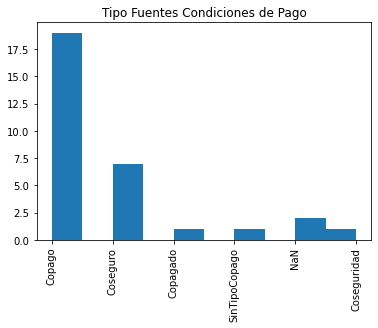

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.set_title('Tipo Fuentes Condiciones de Pago')
ax1.hist(np.array(fuentes.select('Tipo').collect()))
plt.xticks(rotation=90)

El análisis anterior es muy útil para variables de tipo numérico, sin embargo es incompleto para las variables de tipo caracter o las variables categoricas, por ende es necesario implementar nuestro propio código par obtener estadisticos como la moda y la mediana. A continuación obtenemos la moda para la variable Descripcion:

## Análisis de calidad de datos
La calidad de los datos consiste en validar la idoneidad de los datos analizando varias dimensiones, entre las cuales resaltamos:
- Completitud: Datos que no existen o no se conocen
- Unicidad (Duplicidad): Datos que son idénticos en diferentes registros o registros con valores idénticos en atributos en los que no debería ocurrir
- Consistencia: Esta medida se define por la validez o integridad del dato, en la definición de su estructura, al interior de una fila o entre diferentes filas de la misma fuente o de diferentes fuentes. El manejo de unidades en los datos y el significado del dato son generadores de inconsistencias.
- Validez: a nivel de formato y de sentido de los datos más alla de sus valores

Para asegurar una calidad mínima de los datos en estas dimensiones hay que entender su origen y posteriormente realizar un proceso de validación de cada una de las dimensiones de perfilamiento que llevará a un entendimiento de los datos disponibles.


A continuación se definen dos funciones, la primera cuenta los valores vacios por columna de dataframe, la segunda retorna un diccionario de columnas con cardinalidad superior al 50%

Te invito a revisar los recursos de calidad de datos que hemos visto en el curso, a continuacion ejemplos daremos algunos ejemplos por cada dimensión para el caso del tutorial

### Unicidad y validez

La unicidad se revisó en la segunda regla de negocio y la validez se reviso en el perfilamiento general, en la regla de negocio 3 y en el análisis de la descripción al final de la sección de revisión de reglas de negocio

### Completitud y validez

In [50]:
def contar_vacios(df):
    resultados = []
    for c in df.columns:
        vacios_1 = df.filter(df[c].isNull()).count()
        vacios_2 = df.filter(df[c] == "NaN").count()
        vacios = vacios_1 + vacios_2
        if vacios!=0:
            print('número de vacíos para columna '+c+': '+str( vacios ))
            resultados.append(vacios)
    return resultados

def cardinalidad(df):
    resultado = {}
    for c in df.columns:
        cardinalidad = df.select(col(c)).distinct().count()
        if cardinalidad>=df.count()*0.5:
            resultado[c] = cardinalidad
    return resultado

In [52]:
columnas_vacias_ordenes = contar_vacios(fuentes)

número de vacíos para columna Tipo: 2


In [53]:
columnas_alta_cardinalidad = cardinalidad(fuentes)

Como podemos observar para las ordenes las columnas Tipo tiene 2 vacios, definidos como NaN 
Respecto a cardinalidad, Ninguna columna tiene una cardinalidad superior al 50%.